# SQL ON SHELL

**SERHAT ÇEVİKEL**

First let's start our PostgreSQL server again:

In [1]:
sudo service postgresql start

[ ok .


In order to check whether the server is responding by:

In [ ]:
psql -U postgres -c "\l"

Now let's create our environment variables and extract the zipped tsv files if they are not yet:

In [ ]:
datadir=~/data
imdbdir=$datadir/imdb

In [ ]:
mkdir -p $imdbdir/tsv2

In [ ]:
find $imdbdir/tsv -mindepth 1 | \
    parallel -k -j0 "basenm=\$(basename {});
        if [ ! -e ${imdbdir}/tsv2/\${basenm%.gz} ];
        then
            gunzip -c {} > \
            ${imdbdir}/tsv2/\${basenm%.gz};
        fi
        "

Now we will go through two similar shell tools to use sql syntax on csv or tsv files:

## Q

The source page for q project is:

https://github.com/harelba/q

```
q - Text as Data

q is a command line tool that allows direct execution of SQL-like queries on CSVs/TSVs (and any other tabular text files).

q treats ordinary files as database tables, and supports all SQL constructs, such as WHERE, GROUP BY, JOINs etc. It supports automatic column name and column type detection, and provides full support for multiple encodings.

q's web site is http://harelba.github.io/q/. It contains everything you need to download and use q in no time.
```

The tsv files are as follows:

In [ ]:
tldr q

In [ ]:
ls $imdbdir/tsv2

A very basic query taking stdin as input: 

In [ ]:
cat $imdbdir/tsv2/title.ratings.tsv | \
q -t -H "SELECT * \
FROM - \
WHERE tconst = 'tt0000001';"

Or use the filename inside FROM clause:

In [ ]:
q -t -H "SELECT * \
FROM $imdbdir/tsv2/title.ratings.tsv \
WHERE tconst = 'tt0000001';"

## CSVSQL

Part of the csvkit suite:

https://github.com/wireservice/csvkit

https://csvkit.readthedocs.io/en/1.0.3/

In [ ]:
cat $imdbdir/tsv2/title.ratings.tsv | csvsql -t --query "SELECT * \
FROM stdin \
WHERE tconst = 'tt0000001';"

# COMMON TABLE EXPRESSIONS IN SQL (WITH QUERIES)

In order to use sql magic on Python3 kernel:

In [1]:
%load_ext sql

In [2]:
%sql postgres://postgres@localhost/imdb2

'Connected: postgres@imdb2'

You can remember the structure of the data by either typing:

In [ ]:
psql -U postgres -d imdb2 -c "\d+ public.*"

Or viewing the file:

In [ ]:
cat ~/imdb_database

## Godfather cast with CTE's

Now let's remember the query from session 2:


- Filter for movies titled Godfather.\\*Part
- Genres include drama and exclude comedy
- Start year not after 1990
- People with primary profession actor|actress

- First join titles and principal cast on title id's (tconst)
- And then join principal cast and name basics on name id's (nconst)
- Filter only for actors and actresses
- And sort on first names (ascending) then title years

In [ ]:
%%sql

SELECT tb.tconst, tb.originaltitle, tb.startyear, tb.runtimeminutes, tb.genres,
    tp.principalcast,
    nb.primaryname, nb.birthyear, nb.deathyear, nb.primaryprofession

FROM title_basics tb
LEFT JOIN title_principals_melt tp USING (tconst)
	LEFT JOIN name_basics nb ON tp.principalcast=nb.nconst

WHERE tb.originaltitle ~ 'Godfather.*Part'
	AND tb.genres ~ '(?i)drama'
	AND NOT tb.genres ~ '(?i)comedy'
	AND tb.startyear <= 1990
	AND nb.primaryprofession ~'actor|actress'

ORDER BY nb.primaryname, tb.startyear DESC;

We can design this query so that smaller steps are combined:

- Now let's rewrite the previous query with common table expressions (CTE) (aka "WITH" queries)
- With CTE, we run a subquery or multiple subqueries before the main query, name it/them, refer to other subqueries with those names
- And reuse the subqueries in multiple places in the main query - referring by its name, since PostgreSQL stores the results of subqueries
- Just like a table!

In [4]:
%%sql

WITH basics_principles AS
(
SELECT tb.tconst, tb.originaltitle, tb.startyear, tb.runtimeminutes,
	tb.genres, tp.principalcast
FROM title_basics tb
    LEFT JOIN title_principals_melt tp
    USING (tconst)
WHERE tb.originaltitle ~ '.*Godfather.*Part.*'
	AND tb.genres ~ '(?i)drama'
	AND NOT tb.genres ~ '(?i)comedy'
	AND tb.startyear <= 1990
)
SELECT bp.tconst, bp.originaltitle, bp.startyear, bp.runtimeminutes,
	bp.genres, bp.principalcast, nb.primaryname,
	nb.birthyear, nb.deathyear, nb.primaryprofession

FROM basics_principles bp LEFT JOIN name_basics nb ON bp.principalcast=nb.nconst

WHERE nb.primaryprofession ~'actor|actress'

ORDER BY nb.primaryname, bp.startyear DESC;

 * postgres://postgres@localhost/imdb2
8 rows affected.


tconst,originaltitle,startyear,runtimeminutes,genres,principalcast,primaryname,birthyear,deathyear,primaryprofession
tt0099674,The Godfather: Part III,1990,162,"Crime,Drama",nm0000199,Al Pacino,1940,None,"actor,soundtrack,director"
tt0071562,The Godfather: Part II,1974,202,"Crime,Drama",nm0000199,Al Pacino,1940,None,"actor,soundtrack,director"
tt0099674,The Godfather: Part III,1990,162,"Crime,Drama",nm0000412,Andy Garcia,1956,None,"actor,producer,soundtrack"
tt0099674,The Godfather: Part III,1990,162,"Crime,Drama",nm0000473,Diane Keaton,1946,None,"actress,producer,director"
tt0071562,The Godfather: Part II,1974,202,"Crime,Drama",nm0000473,Diane Keaton,1946,None,"actress,producer,director"
tt0071562,The Godfather: Part II,1974,202,"Crime,Drama",nm0000134,Robert De Niro,1943,None,"actor,producer,soundtrack"
tt0071562,The Godfather: Part II,1974,202,"Crime,Drama",nm0000380,Robert Duvall,1931,None,"actor,producer,soundtrack"
tt0099674,The Godfather: Part III,1990,162,"Crime,Drama",nm0001735,Talia Shire,1946,None,"actress,producer,director"


## De Niro and Scorsese

This was already easily implemented without CTE's.

Now a harder example which is much challenging to implement without CTE's:

Return all fields from title_basics for "movies" which feature Martin Scorsese as director and Robert De Niro as actor, sorted by ascending startyear

In [4]:
%%sql

-- first get the nconst of Martin Scorsese
WITH ms_id AS
(
SELECT nb.nconst
FROM name_basics nb
WHERE nb.primaryname = 'Martin Scorsese'
	AND nb.primaryprofession ~ 'director'
),
-- then get the titles directed by Martin Scorsese
ms_titles AS
(
SELECT tc.tconst
FROM ms_id LEFT JOIN title_crew tc ON ms_id.nconst=tc.directors
),
-- and get the nconst of Robert De Niro
rdn_id AS
(
SELECT nb.nconst
FROM name_basics nb
WHERE nb.primaryname = 'Robert De Niro'
),
-- and get the titles by Robert De Niro
rdn_titles AS
(
SELECT tp.tconst
FROM rdn_id LEFT JOIN title_principals_melt tp ON rdn_id.nconst=tp.principalcast
)
-- and last, get the intersection of titles by De Niro and Scorsese
SELECT tb.*
FROM ms_titles INNER JOIN rdn_titles ON ms_titles.tconst=rdn_titles.tconst
LEFT JOIN title_basics tb ON rdn_titles.tconst=tb.tconst
WHERE tb.titletype = 'movie'
ORDER BY tb.startyear


 * postgres://postgres@localhost/imdb2
9 rows affected.


tconst,titletype,primarytitle,originaltitle,isadult,startyear,endyear,runtimeminutes,genres
tt0070379,movie,Mean Streets,Mean Streets,False,1973,None,112,"Crime,Drama,Thriller"
tt0075314,movie,Taxi Driver,Taxi Driver,False,1976,None,113,"Crime,Drama"
tt0076451,movie,"New York, New York","New York, New York",False,1977,None,155,"Drama,Music,Musical"
tt0081398,movie,Raging Bull,Raging Bull,False,1980,None,129,"Biography,Drama,Sport"
tt0085794,movie,The King of Comedy,The King of Comedy,False,1982,None,109,"Comedy,Crime,Drama"
tt0099685,movie,Goodfellas,Goodfellas,False,1990,None,146,"Crime,Drama"
tt0101540,movie,Cape Fear,Cape Fear,False,1991,None,128,"Crime,Thriller"
tt0112641,movie,Casino,Casino,False,1995,None,178,"Crime,Drama"
tt1302006,movie,The Irishman,The Irishman,False,2018,None,None,"Biography,Crime,Drama"


## Ratings of Al Pacino

Now another:


- Return all the fields from title_basics and "averagerating" field from title_ratings of the "movies" that Al Pacino took role in
- Exclude titles which have no "averagerating" info (with "IS NOT NULL" logical test)
- Order by descending averageratings
- Note that: In order to get the id of Al Pacino, from the name_basics table, you should check the "primaryname" field for equality with "Al Pacino" and birthyear with "1940"  
- You can use multiple "common table expressions" (CTE) or "WITH" queries to simplify the main query
- You can use aliases for tables to simplify your query (e.g. FROM title_basics tb)

In [3]:
%%sql

-- get the nconst of pacino
WITH pacino AS
(
SELECT nconst
FROM name_basics nb
WHERE nb.primaryname = 'Al Pacino'
	AND nb.birthyear = 1940
),
-- get the titles of pacino
t_ids AS
(
SELECT tp.tconst
FROM pacino LEFT JOIN title_principals_melt tp ON pacino.nconst=tp.principalcast
)
-- get the details of those titles
SELECT tb.*, tr.averagerating
FROM t_ids LEFT JOIN title_basics tb ON t_ids.tconst=tb.tconst
	LEFT JOIN title_ratings tr ON tb.tconst=tr.tconst
WHERE tb.titletype = 'movie'
	AND tr.averagerating IS NOT NULL
ORDER BY tr.averagerating DESC	

 * postgres://postgres@localhost/imdb2
48 rows affected.


tconst,titletype,primarytitle,originaltitle,isadult,startyear,endyear,runtimeminutes,genres,averagerating
tt0068646,movie,The Godfather,The Godfather,False,1972,None,175,"Crime,Drama",9.2
tt0071562,movie,The Godfather: Part II,The Godfather: Part II,False,1974,None,202,"Crime,Drama",9.0
tt5126922,movie,Dabka,Dabka,False,2017,None,116,"Biography,Drama",8.8
tt0086250,movie,Scarface,Scarface,False,1983,None,170,"Crime,Drama",8.3
tt0113277,movie,Heat,Heat,False,1995,None,170,"Action,Crime,Drama",8.2
tt0072890,movie,Dog Day Afternoon,Dog Day Afternoon,False,1975,None,125,"Biography,Crime,Drama",8.0
tt0105323,movie,Scent of a Woman,Scent of a Woman,False,1992,None,156,Drama,8.0
tt0140352,movie,The Insider,The Insider,False,1999,None,157,"Biography,Drama,Thriller",7.9
tt0106519,movie,Carlito's Way,Carlito's Way,False,1993,None,144,"Crime,Drama,Thriller",7.9
tt0104348,movie,Glengarry Glen Ross,Glengarry Glen Ross,False,1992,None,100,"Crime,Drama,Mystery",7.8


## Youngest cast of each movie, revisited

**EXERCISE 1:**

Now remember the last query from session 3, in which we tried to get the oldest cast of each filtered movie.

With CTE's we can do it in a more efficient and neat way:


- Select movies with averagerating > 8.8, numvotes > 500000, titletype is not tvSeries
- Now calculate the max birthyear of the cast of each movies and select those names with max birthyear, hence youngest cast
- Report primarytitle, primaryname, birthyear of cast, startyear of movie and age of the youngest cast at the time of the movie (just the difference of previous two columns aliased as "age"

The version with subquery was as such:


```SQL
SELECT mb.primarytitle, nb.birthyear, tb.startyear, tb.startyear - nb.birthyear as age,nb.primaryname
    FROM
(
SELECT tb.primarytitle, max(nb.birthyear) as maxbirthyear, tb.tconst 
FROM title_basics tb
    LEFT JOIN title_ratings tr USING (tconst)
    LEFT JOIN title_principals_melt tp USING (tconst)
    LEFT JOIN name_basics nb ON nb.nconst=tp.principalcast
WHERE tr.averagerating > 8.8
    AND tr.numvotes > 500000
    AND NOT tb.titletype = 'tvSeries'
GROUP BY tb.primarytitle, tb.tconst
) mb
    LEFT JOIN title_basics tb USING (tconst)
    LEFT JOIN title_principals_melt tp USING (tconst)
    LEFT JOIN name_basics nb ON nb.nconst=tp.principalcast
WHERE nb.birthyear = mb.maxbirthyear
```

and the basic query listing the primary casts was as such:

```SQL
SELECT tb.primarytitle, tb.startyear, nb.primaryname, nb.birthyear, tr.averagerating
FROM title_basics tb
    LEFT JOIN title_ratings tr USING (tconst)
    LEFT JOIN title_principals_melt tp USING (tconst)
    LEFT JOIN name_basics nb ON nb.nconst=tp.principalcast
WHERE tr.averagerating > 8.8
    AND tr.numvotes > 500000
    AND NOT tb.titletype = 'tvSeries'
ORDER BY nb.primaryname, tb.primarytitle;
```

In [ ]:
%%sql

-- statement here

In [ ]:
psql -U postgres -d imdb2 <<EOF

-- or you may write your statement here
EOF

**SOLUTION 1:**

In [5]:
pass1=3082
encrypt=$(cat encrypt_04_01)
solution=$(echo "$encrypt" | openssl enc -aes-128-cbc -a -d -salt -pass pass:$pass1 2> /dev/null)
echo "$solution"; echo
for l in "$solution"; do eval "${l}"; done

psql -U postgres -d imdb2 <<EOF
-- the basic query listing the primary casts was as such:
WITH cast1 AS

SELECT tb.tconst, tb.primarytitle, tb.startyear, nb.primaryname, nb.birthyear
FROM title_basics tb
    LEFT JOIN title_ratings tr USING (tconst)
    LEFT JOIN title_principals_melt tp USING (tconst)
    LEFT JOIN name_basics nb ON nb.nconst=tp.principalcast
WHERE tr.averagerating > 8.8
    AND tr.numvotes > 500000
    AND NOT tb.titletype = 'tvSeries'
ORDER BY nb.primaryname, tb.primarytitle
),
-- get the maxbirth of each movie
maxbirth AS

SELECT max(cast1.birthyear) as maxbirthyear, cast1.tconst 
FROM cast1
.primarytitle, cast1.tconst

-- combine both
SELECT cast1.*, cast1.startyear - cast1.birthyear as age
    FROM cast1
    LEFT JOIN maxbirth mb USING (tconst)
    WHERE mb.maxbirthyear = cast1.birthyear;
EOF

  tconst   |                 primarytitle                  | startyear |  primaryname   | birthyear | age 
-----------+-----------------------------------------------+-----

# SQL FROM R

Now we will see how we can access to a PostgreSQL database from R

## Using RPostgreSQL package

First load necessary package

In [6]:
library(RPostgreSQL)

Loading required package: DBI


Load PostgreSQL driver

In [7]:
drvv <- dbDriver("PostgreSQL")
drvv

<PostgreSQLDriver>

Create a connection to a database using the driver

In [8]:
con <- dbConnect(drvv,
                 dbname = "imdb2",
                 host = "localhost",
                 port = 5432,
                 user = "postgres")

con

<PostgreSQLConnection>

Get list of table names

In [9]:
table_names <- dbGetQuery(con,
                          "SELECT table_name
                          FROM information_schema.tables 
                          WHERE table_type = 'BASE TABLE'
                          AND table_schema = 'public'
                          ORDER BY table_name
                          "
                          )

table_names

class(table_names)

table_name
<chr>
crew_molten
genres_molten
name_basics
title_basics
title_crew
title_episode
title_principals_melt
title_ratings


[1] "data.frame"

Or more easily with:

In [10]:
dbListTables(con)

[1] "crew_molten"           "genres_molten"         "name_basics"          
[4] "title_basics"          "title_crew"            "title_episode"        
[7] "title_principals_melt" "title_ratings"

Good! The query returns a data frame

Now we can loop through tables to automatize queries

List tables:

In [11]:
table_names_vec <- dbListTables(con)
table_names_vec
class(table_names_vec)

[1] "crew_molten"           "genres_molten"         "name_basics"          
[4] "title_basics"          "title_crew"            "title_episode"        
[7] "title_principals_melt" "title_ratings"

[1] "character"

This yields a character vector, not a data frame

Get row counts

In [12]:
# create a query template that we can change the parameters of
# each "%s" stands for a variable that we will manipulate with sprintf
query_text <- "SELECT count (*) FROM %s"

# create an empty vector, the length of the table names
# we will populate this vector with the row counts from tables
row_counts <- rep(NA, length(table_names_vec))

# update the names of the vector with table names
names(row_counts) <- table_names_vec

# for across table names indices (not the names themselves)
for (tbl_ind in seq_along(table_names_vec))
{
    # replace the %s pointer in query text with table name
    current_query <- sprintf(query_text, table_names_vec[tbl_ind])
    
    # run the query and get results
    table_name <- dbGetQuery(con, current_query)
    
    # assign the query result to vector
    row_counts[tbl_ind] <- table_name[[1]]
}
                  
return(row_counts)

crew_molten         genres_molten           name_basics 
             12372393               7168553               8155447 
         title_basics            title_crew         title_episode 
              4534354               4534354               2986925 
title_principals_melt         title_ratings 
             25358895                767041

### Play with title_ratings

Let's import a table as a data frame into R

In [13]:
title_ratings_df <- dbGetQuery(con, "SELECT * from title_ratings")

Get the head, attributes and summary of the data frame

In [14]:
head(title_ratings_df)

tconst,averagerating,numvotes
<chr>,<dbl>,<int>
tt0000001,5.8,1306
tt0000002,6.5,149
tt0000003,6.6,885
tt0000004,6.4,92
tt0000005,6.2,1565
tt0000006,5.7,73


In [15]:
class(title_ratings_df)

[1] "data.frame"

Now an easier way to read data into R

In [16]:
title_ratings_df_b <- dbReadTable(con, "title_ratings")

See whether they are identical objects

In [17]:
identical(title_ratings_df, title_ratings_df_b)

[1] TRUE

So, they are identical

What is the object size of each data frame?

In [18]:
format(object.size(title_ratings_df), units = "auto")

[1] "61.4 Mb"

In [19]:
format(object.size(title_ratings_df_b), units = "auto")

[1] "61.4 Mb"

They take too much space. Now let's get rid of one of them

In [20]:
rm(title_ratings_df_b)

New get the classes of all columns

In [21]:
str(title_ratings_df)

'data.frame':	767041 obs. of  3 variables:
 $ tconst       : chr  "tt0000001" "tt0000002" "tt0000003" "tt0000004" ...
 $ averagerating: num  5.8 6.5 6.6 6.4 6.2 5.7 5.5 5.6 5.4 6.9 ...
 $ numvotes     : int  1306 149 885 92 1565 73 524 1386 58 4674 ...


### Play with title_basics

Let's query title_basics as such:

Let's say, take rows in which 

name contains "Star Wars",

not an adult movie

title_type is a movie and

start year is between 1977 and 2016

In [22]:
title_basics_df2 <- dbGetQuery(con,
                          "SELECT *
                            FROM title_basics 
                            WHERE primarytitle ~* 'star.*wars'
                            AND isadult = false
                            AND titletype = 'movie'
                            AND startyear BETWEEN 1977 AND 2016"
                          )

In [23]:
title_basics_df2

tconst,titletype,primarytitle,originaltitle,isadult,startyear,endyear,runtimeminutes,genres
<chr>,<chr>,<chr>,<chr>,<lgl>,<int>,<int>,<int>,<chr>
tt0080684,movie,Star Wars: Episode V - The Empire Strikes Back,Star Wars: Episode V - The Empire Strikes Back,FALSE,1980,NA,124,"Action,Adventure,Fantasy"
tt0076759,movie,Star Wars: Episode IV - A New Hope,Star Wars,FALSE,1977,NA,121,"Action,Adventure,Fantasy"
tt0121765,movie,Star Wars: Episode II - Attack of the Clones,Star Wars: Episode II - Attack of the Clones,FALSE,2002,NA,142,"Action,Adventure,Fantasy"
tt0086190,movie,Star Wars: Episode VI - Return of the Jedi,Star Wars: Episode VI - Return of the Jedi,FALSE,1983,NA,131,"Action,Adventure,Fantasy"
tt0120915,movie,Star Wars: Episode I - The Phantom Menace,Star Wars: Episode I - The Phantom Menace,FALSE,1999,NA,136,"Action,Adventure,Fantasy"
tt0121766,movie,Star Wars: Episode III - Revenge of the Sith,Star Wars: Episode III - Revenge of the Sith,FALSE,2005,NA,140,"Action,Adventure,Fantasy"
tt1970025,movie,Star Wars Heroes & Villains,Star Wars Heroes & Villains,FALSE,2005,NA,68,Documentary
tt1140851,movie,Bob Hope's All-Star Look at TV's Prime Time Wars,Bob Hope's All-Star Look at TV's Prime Time Wars,FALSE,1980,NA,60,Comedy
tt1432993,movie,Star Wars: A Galaxy in Darkness,Star Wars: A Galaxy in Darkness,FALSE,2009,NA,46,"Adventure,Drama,Sci-Fi"


In [24]:
str(title_basics_df2)

'data.frame':	22 obs. of  9 variables:
 $ tconst        : chr  "tt0080684" "tt0076759" "tt0121765" "tt0086190" ...
 $ titletype     : chr  "movie" "movie" "movie" "movie" ...
 $ primarytitle  : chr  "Star Wars: Episode V - The Empire Strikes Back" "Star Wars: Episode IV - A New Hope" "Star Wars: Episode II - Attack of the Clones" "Star Wars: Episode VI - Return of the Jedi" ...
 $ originaltitle : chr  "Star Wars: Episode V - The Empire Strikes Back" "Star Wars" "Star Wars: Episode II - Attack of the Clones" "Star Wars: Episode VI - Return of the Jedi" ...
 $ isadult       : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ startyear     : int  1980 1977 2002 1983 1999 2005 2005 1980 2009 2004 ...
 $ endyear       : int  NA NA NA NA NA NA NA NA NA NA ...
 $ runtimeminutes: int  124 121 142 131 136 140 68 60 46 NA ...
 $ genres        : chr  "Action,Adventure,Fantasy" "Action,Adventure,Fantasy" "Action,Adventure,Fantasy" "Action,Adventure,Fantasy" ...


Did not like NA's in tconst, let's enhance it

In [25]:
title_basics_df3 <- title_basics_df2[
    !is.na(title_basics_df2$tconst),
]

In [26]:
title_basics_df3

tconst,titletype,primarytitle,originaltitle,isadult,startyear,endyear,runtimeminutes,genres
<chr>,<chr>,<chr>,<chr>,<lgl>,<int>,<int>,<int>,<chr>
tt0080684,movie,Star Wars: Episode V - The Empire Strikes Back,Star Wars: Episode V - The Empire Strikes Back,FALSE,1980,NA,124,"Action,Adventure,Fantasy"
tt0076759,movie,Star Wars: Episode IV - A New Hope,Star Wars,FALSE,1977,NA,121,"Action,Adventure,Fantasy"
tt0121765,movie,Star Wars: Episode II - Attack of the Clones,Star Wars: Episode II - Attack of the Clones,FALSE,2002,NA,142,"Action,Adventure,Fantasy"
tt0086190,movie,Star Wars: Episode VI - Return of the Jedi,Star Wars: Episode VI - Return of the Jedi,FALSE,1983,NA,131,"Action,Adventure,Fantasy"
tt0120915,movie,Star Wars: Episode I - The Phantom Menace,Star Wars: Episode I - The Phantom Menace,FALSE,1999,NA,136,"Action,Adventure,Fantasy"
tt0121766,movie,Star Wars: Episode III - Revenge of the Sith,Star Wars: Episode III - Revenge of the Sith,FALSE,2005,NA,140,"Action,Adventure,Fantasy"
tt1970025,movie,Star Wars Heroes & Villains,Star Wars Heroes & Villains,FALSE,2005,NA,68,Documentary
tt1140851,movie,Bob Hope's All-Star Look at TV's Prime Time Wars,Bob Hope's All-Star Look at TV's Prime Time Wars,FALSE,1980,NA,60,Comedy
tt1432993,movie,Star Wars: A Galaxy in Darkness,Star Wars: A Galaxy in Darkness,FALSE,2009,NA,46,"Adventure,Drama,Sci-Fi"


Much better!

Now let's write this data frame into our imdb2 database as a new table

In [27]:
dbWriteTable(con, "star_wars",
             value = title_basics_df3,
             append = TRUE, row.names = FALSE)

[1] TRUE

Check whether table is created:

In [28]:
dbExistsTable(con, "star_wars")

[1] TRUE

And read from the database again

In [29]:
star_wars <- dbReadTable(con, "star_wars")

star_wars

tconst,titletype,primarytitle,originaltitle,isadult,startyear,endyear,runtimeminutes,genres
<chr>,<chr>,<chr>,<chr>,<lgl>,<int>,<int>,<int>,<chr>
tt0080684,movie,Star Wars: Episode V - The Empire Strikes Back,Star Wars: Episode V - The Empire Strikes Back,FALSE,1980,NA,124,"Action,Adventure,Fantasy"
tt0076759,movie,Star Wars: Episode IV - A New Hope,Star Wars,FALSE,1977,NA,121,"Action,Adventure,Fantasy"
tt0121765,movie,Star Wars: Episode II - Attack of the Clones,Star Wars: Episode II - Attack of the Clones,FALSE,2002,NA,142,"Action,Adventure,Fantasy"
tt0086190,movie,Star Wars: Episode VI - Return of the Jedi,Star Wars: Episode VI - Return of the Jedi,FALSE,1983,NA,131,"Action,Adventure,Fantasy"
tt0120915,movie,Star Wars: Episode I - The Phantom Menace,Star Wars: Episode I - The Phantom Menace,FALSE,1999,NA,136,"Action,Adventure,Fantasy"
tt0121766,movie,Star Wars: Episode III - Revenge of the Sith,Star Wars: Episode III - Revenge of the Sith,FALSE,2005,NA,140,"Action,Adventure,Fantasy"
tt1970025,movie,Star Wars Heroes & Villains,Star Wars Heroes & Villains,FALSE,2005,NA,68,Documentary
tt1140851,movie,Bob Hope's All-Star Look at TV's Prime Time Wars,Bob Hope's All-Star Look at TV's Prime Time Wars,FALSE,1980,NA,60,Comedy
tt1432993,movie,Star Wars: A Galaxy in Darkness,Star Wars: A Galaxy in Darkness,FALSE,2009,NA,46,"Adventure,Drama,Sci-Fi"


See, the only difference seems to be the rownames which we excluded on purpose

Apart from that, let's check whet they are both identical

In [30]:
attributes(title_basics_df3)

$names
[1] "tconst"         "titletype"      "primarytitle"   "originaltitle" 
[5] "isadult"        "startyear"      "endyear"        "runtimeminutes"
[9] "genres"        

$row.names
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22

$class
[1] "data.frame"

In [31]:
rownames(title_basics_df3) <- NULL
title_basics_df3

tconst,titletype,primarytitle,originaltitle,isadult,startyear,endyear,runtimeminutes,genres
<chr>,<chr>,<chr>,<chr>,<lgl>,<int>,<int>,<int>,<chr>
tt0080684,movie,Star Wars: Episode V - The Empire Strikes Back,Star Wars: Episode V - The Empire Strikes Back,FALSE,1980,NA,124,"Action,Adventure,Fantasy"
tt0076759,movie,Star Wars: Episode IV - A New Hope,Star Wars,FALSE,1977,NA,121,"Action,Adventure,Fantasy"
tt0121765,movie,Star Wars: Episode II - Attack of the Clones,Star Wars: Episode II - Attack of the Clones,FALSE,2002,NA,142,"Action,Adventure,Fantasy"
tt0086190,movie,Star Wars: Episode VI - Return of the Jedi,Star Wars: Episode VI - Return of the Jedi,FALSE,1983,NA,131,"Action,Adventure,Fantasy"
tt0120915,movie,Star Wars: Episode I - The Phantom Menace,Star Wars: Episode I - The Phantom Menace,FALSE,1999,NA,136,"Action,Adventure,Fantasy"
tt0121766,movie,Star Wars: Episode III - Revenge of the Sith,Star Wars: Episode III - Revenge of the Sith,FALSE,2005,NA,140,"Action,Adventure,Fantasy"
tt1970025,movie,Star Wars Heroes & Villains,Star Wars Heroes & Villains,FALSE,2005,NA,68,Documentary
tt1140851,movie,Bob Hope's All-Star Look at TV's Prime Time Wars,Bob Hope's All-Star Look at TV's Prime Time Wars,FALSE,1980,NA,60,Comedy
tt1432993,movie,Star Wars: A Galaxy in Darkness,Star Wars: A Galaxy in Darkness,FALSE,2009,NA,46,"Adventure,Drama,Sci-Fi"


In [32]:
identical(title_basics_df3, star_wars)

[1] TRUE

Yes they are identical!

### Primary constraints

Let's remove the table

In [33]:
dbRemoveTable(con, "star_wars")

[1] TRUE

Check whether it still exists

In [34]:
dbExistsTable(con, "star_wars")

[1] FALSE

Now let's create the table again

In [35]:
dbWriteTable(con, "star_wars",
             value = title_basics_df3, append = TRUE, row.names = FALSE)

[1] TRUE

Check that it exists:

In [36]:
dbExistsTable(con, "star_wars")

[1] TRUE

Get its rowcount:

In [37]:
dbGetQuery(con, "SELECT count (*) FROM star_wars")

count
<dbl>
22


And repeat the data write statement, with append option

In [38]:
dbWriteTable(con, "star_wars",
             value = title_basics_df3,
             append = TRUE, row.names = FALSE)

[1] TRUE

Get the rowcount again

In [39]:
dbGetQuery(con, "SELECT count (*) FROM star_wars")

count
<dbl>
44


<a href="https://www.youtube.com/embed/tsXEToflqGs?start=10&autoplay=1">OW! I HAVE A BAD FEELING ABOUT THIS</a>

We did not define a primary key, so postgresql server allowed duplicates to be inserted in to the database

Now delete and recreate table

In [40]:
dbRemoveTable(con, "star_wars")

[1] TRUE

In [41]:
dbExistsTable(con, "star_wars")

[1] FALSE

In [42]:
dbWriteTable(con, "star_wars",
             value = title_basics_df3,
             append = TRUE, row.names = FALSE)

[1] TRUE

In [43]:
dbExistsTable(con, "star_wars")

[1] TRUE

And add a primary key constraint

In [44]:
dbGetQuery(con,           
"
ALTER TABLE star_wars
ADD CONSTRAINT tconst_pk_10 
PRIMARY KEY (tconst);
")

<0 x 0 matrix>

Let's try to import the data again

In [45]:
dbWriteTable(con, "star_wars",
             value = title_basics_df3,
             append = TRUE, row.names = FALSE)

ERROR: Error in postgresqlgetResult(new.con): RS-DBI driver: (could not Retrieve the result : ERROR:  duplicate key value violates unique constraint "tconst_pk_10"
DETAIL:  Key (tconst)=(tt0080684) already exists.
CONTEXT:  COPY star_wars, line 1
)


See that:

***could not Retrieve the result : ERROR:  duplicate key value violates unique constraint "tconst_pk_10***

Let's check the row count again:

In [46]:
dbGetQuery(con, "SELECT count (*) FROM star_wars")

count
<dbl>
22


OK, we duplicates were really not allowed!

Let's close connection

In [47]:
dbDisconnect(con)

[1] TRUE

And unload the driver

In [48]:
dbUnloadDriver(drvv)

[1] TRUE

## Using sqldf package

First let's load the package:

In [49]:
library(RPostgreSQL)
library(sqldf)

Loading required package: gsubfn
Loading required package: proto
Warning message:
“no DISPLAY variable so Tk is not available”Loading required package: RSQLite
sqldf will default to using PostgreSQL


And set the options:

In [50]:
options(sqldf.RPostgreSQL.user ="postgres", 
  sqldf.RPostgreSQL.dbname ="imdb2",
  sqldf.RPostgreSQL.host ="localhost", 
  sqldf.RPostgreSQL.port =5432)

### Average runtimes

Now let's run a query to get average runtimeminutes from title_basics and group them and order them by startyear  

In [51]:
query = "SELECT avg(runtimeminutes) runtimeminutes, startyear 
            FROM title_basics
            GROUP BY startyear
            ORDER BY startyear;"

av_runtime <- sqldf(query)

In [52]:
av_runtime

class(av_runtime)

runtimeminutes,startyear
<dbl>,<int>
NA,1874
1.000000,1878
1.000000,1883
1.000000,1887
0.750000,1888
NA,1889
1.000000,1890
1.000000,1891
2.750000,1892


[1] "data.frame"

It returns a data frame

Now subset years between 1940 and 2016

In [53]:
av_runtime_subset <- av_runtime[av_runtime$startyear %in% 1940:2016,]

av_runtime_subset

,runtimeminutes,startyear
,<dbl>,<int>
57,61.09644,1940
58,57.72449,1941
59,57.48081,1942
60,59.36931,1943
61,56.20810,1944
62,54.21501,1945
63,55.94784,1946
64,59.17606,1947
65,57.52189,1948


Check whether any NA's exist

In [54]:
which(is.na(av_runtime_subset[[1]]))

integer(0)

Let's plot the data

In [55]:
runtime_ts <- ts(av_runtime_subset[[1]],
                 start = av_runtime_subset[1,2],
                 end = av_runtime_subset[nrow(av_runtime_subset),2])

runtime_ts

A Time Series:
 [1] 61.09644 57.72449 57.48081 59.36931 56.20810 54.21501 55.94784 59.17606
 [9] 57.52189 56.56834 56.46205 54.01933 52.11005 49.62463 51.03129 48.87632
[17] 49.58294 48.39597 48.35943 48.62121 48.83042 50.05591 53.80506 52.50573
[25] 52.99213 52.59998 52.05031 52.48186 56.38770 56.10259 59.82178 60.26476
[33] 61.36278 60.89975 60.52990 59.52395 61.76300 64.26495 63.94847 63.89022
[41] 64.12069 64.82314 64.88972 63.27469 61.43913 60.60667 60.98615 61.86920
[49] 61.05390 59.43898 56.91495 57.82830 57.57734 56.34543 56.31242 56.09262
[57] 55.70441 54.02251 55.54887 54.95757 56.50677 54.43055 53.38782 54.22617
[65] 54.40710 51.29821 48.63466 46.76012 44.21039 41.90973 40.16238 38.81602
[73] 37.54565 36.94529 37.35079 38.74563 38.39977

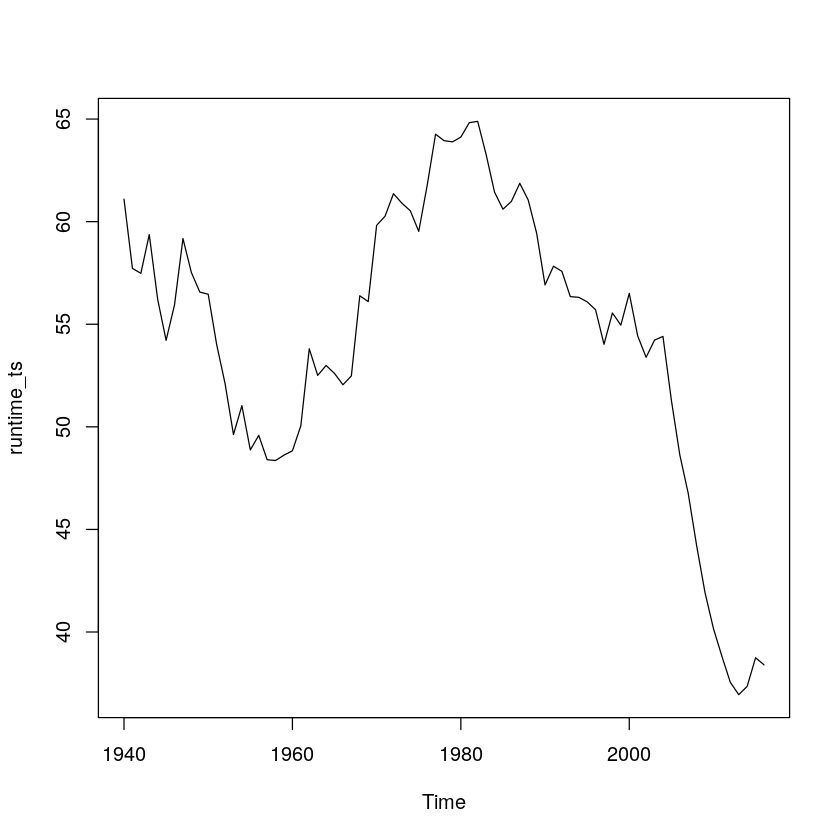

In [56]:
plot(runtime_ts)

Well that data may have many different types of titles including shorts, etc

Let's first subset for movies

In [57]:
query = "SELECT avg(runtimeminutes) runtimeminutes, startyear 
            FROM title_basics
            WHERE titletype = 'movie'
            GROUP BY startyear
            ORDER BY startyear;"

av_runtime <- sqldf(query)

In [58]:
av_runtime

runtimeminutes,startyear
<dbl>,<int>
45.00000,1894
20.00000,1897
NA,1898
135.00000,1899
66.00000,1900
9.00000,1901
NA,1902
NA,1903
68.00000,1904


In [59]:
av_runtime_subset <- av_runtime[av_runtime$startyear %in% 1940:2016,]

av_runtime_subset

,runtimeminutes,startyear
,<dbl>,<int>
45,84.25992,1940
46,86.25596,1941
47,85.38028,1942
48,84.55940,1943
49,84.80455,1944
50,84.85678,1945
51,85.32957,1946
52,86.37474,1947
53,86.72104,1948


In [60]:
runtime_ts <- ts(av_runtime_subset[[1]],
                 start = av_runtime_subset[1,2],
                 end = av_runtime_subset[nrow(av_runtime_subset),2])

runtime_ts

A Time Series:
 [1] 84.25992 86.25596 85.38028 84.55940 84.80455 84.85678 85.32957 86.37474
 [9] 86.72104 88.14210 87.59634 89.07342 88.67294 89.38712 92.05054 92.07099
[17] 91.30238 90.12435 90.59342 91.75738 90.30726 89.30161 90.99763 90.17818
[25] 91.18553 93.31792 92.69657 95.31474 94.71499 91.53991 91.70942 89.61671
[33] 90.48318 89.86605 90.60441 90.09050 90.63739 92.32068 91.24928 90.90727
[41] 91.45959 91.22627 91.75125 90.36928 90.63929 91.64152 90.49673 94.04279
[49] 92.00481 92.52280 91.37899 91.89749 91.65210 91.53488 90.77124 90.53604
[57] 91.11044 90.26044 89.35724 90.90203 90.14773 89.95131 90.72581 89.47469
[65] 91.14913 88.40034 88.63699 88.33691 87.35872 85.57049 85.09991 86.19690
[73] 84.49878 84.67783 84.06408 85.16231 84.93204

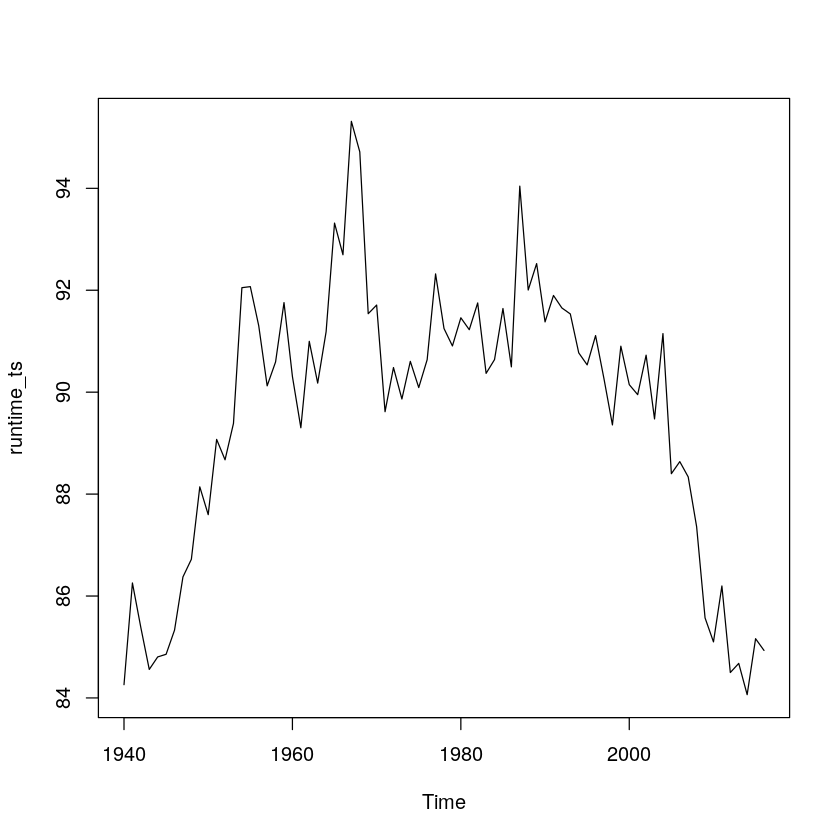

In [61]:
plot(runtime_ts)

### Explore Hitchcock movies

In [62]:
library(RPostgreSQL)

In [63]:
drvv <- dbDriver("PostgreSQL")
drvv

<PostgreSQLDriver>

In [64]:
con <- dbConnect(drvv,
                 dbname = "imdb2",
                 host = "localhost",
                 port = 5432,
                 user = "postgres")

con

<PostgreSQLConnection>

Now the task is:
- First get the count of average rating of movies by Alfred Hitchcock (excluding NULL ratings) with an SQL query
- And summarize these values by decades (total count of movies and average rating by decade)
- You can use floor division by floor(a/b) or its operator %/% in R
- You can use aggregate function in R
- You can recycle all codes that we have written sor far, or use the net
- You can cooperate

In [65]:
query <- "
WITH hitch AS
(
SELECT nconst
FROM name_basics nb
WHERE nb.primaryname = 'Alfred Hitchcock'
	AND nb.primaryprofession ~ 'director'
),
t_ids AS
(
SELECT tp.tconst
FROM hitch LEFT JOIN title_crew tp ON hitch.nconst=tp.directors
)
SELECT startyear, count(*), avg(tr.averagerating) avrate
FROM t_ids LEFT JOIN title_basics tb ON t_ids.tconst=tb.tconst
	LEFT JOIN title_ratings tr ON tb.tconst=tr.tconst
WHERE tb.titletype = 'movie'
	AND tr.averagerating IS NOT NULL
GROUP BY startyear
ORDER BY startyear
"

In [66]:
hitch_df <- dbGetQuery(con, query)

In [67]:
hitch_df

startyear,count,avrate
<int>,<dbl>,<dbl>
1925,1,6.000000
1927,3,6.566667
1928,3,5.766667
1929,2,6.650000
1930,2,5.600000
1931,3,5.900000
1932,1,5.800000
1934,2,6.450000
1935,1,7.800000


In order to get an average rating for each decade weighted with the count of movies for each year, it is good to have a column for sum of ratings for a year:

In [69]:
hitch_df$sumrate <- hitch_df$count * hitch_df$avrate

In [70]:
hitch_df

startyear,count,avrate,sumrate
<int>,<dbl>,<dbl>,<dbl>
1925,1,6.000000,6.0
1927,3,6.566667,19.7
1928,3,5.766667,17.3
1929,2,6.650000,13.3
1930,2,5.600000,11.2
1931,3,5.900000,17.7
1932,1,5.800000,5.8
1934,2,6.450000,12.9
1935,1,7.800000,7.8


Now let's get a column for decades:

In [71]:
hitch_df$dec <- (hitch_df$startyear %/% 10) * 10

In [72]:
hitch_df

startyear,count,avrate,sumrate,dec
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1925,1,6.000000,6.0,1920
1927,3,6.566667,19.7,1920
1928,3,5.766667,17.3,1920
1929,2,6.650000,13.3,1920
1930,2,5.600000,11.2,1930
1931,3,5.900000,17.7,1930
1932,1,5.800000,5.8,1930
1934,2,6.450000,12.9,1930
1935,1,7.800000,7.8,1930


And let's aggregate for each decade the sums of sumrate values:

In [73]:
hitch_agg <- aggregate(hitch_df[,c(2,4)],
                       by = list(hitch_df$dec),
                       FUN = sum)

In [74]:
hitch_agg

Group.1,count,sumrate
<dbl>,<dbl>,<dbl>
1920,9,56.3
1930,14,90.3
1940,12,89.0
1950,11,85.6
1960,5,36.4
1970,2,14.3


And let's get the average rating for each decade, deleting the sumrate column:

In [75]:
hitch_agg$avrate <- hitch_agg$sumrate / hitch_agg$count

In [76]:
hitch_agg$sumrate <- NULL

In [77]:
hitch_agg

Group.1,count,avrate
<dbl>,<dbl>,<dbl>
1920,9,6.255556
1930,14,6.450000
1940,12,7.416667
1950,11,7.781818
1960,5,7.280000
1970,2,7.150000


Let's have a scatterplot of counts versus average ratings

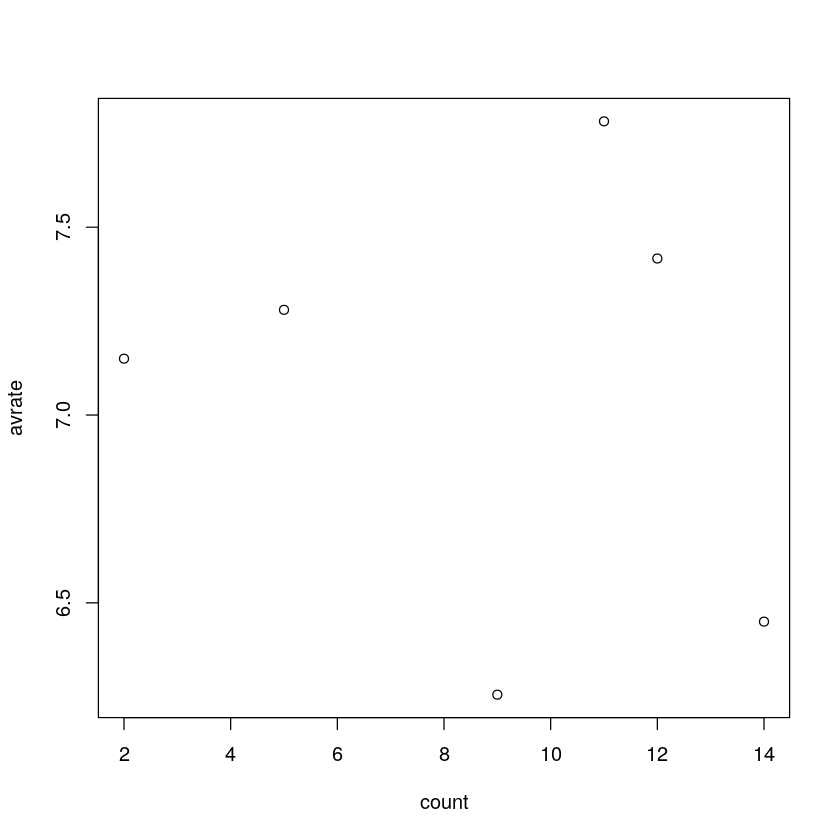

In [78]:
plot(hitch_agg[,-1])

Let's have the total counts by decade:

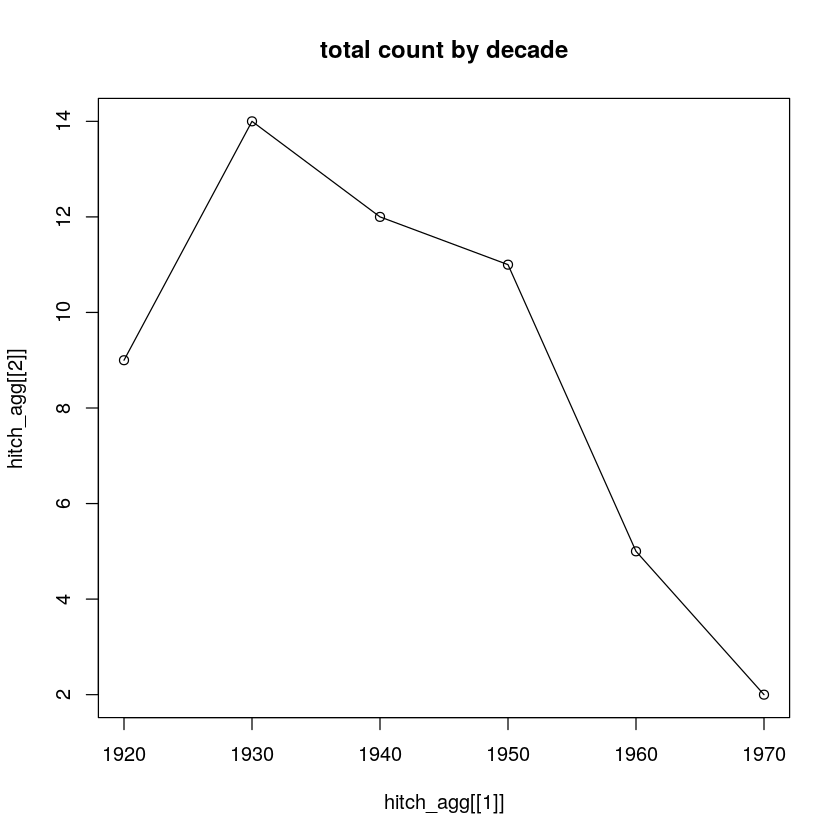

In [79]:
plot(x = hitch_agg[[1]], y = hitch_agg[[2]], main = "total count by decade")
lines(x = hitch_agg[[1]], y = hitch_agg[[2]], type = "l")

And let's have the averate ratings by decade

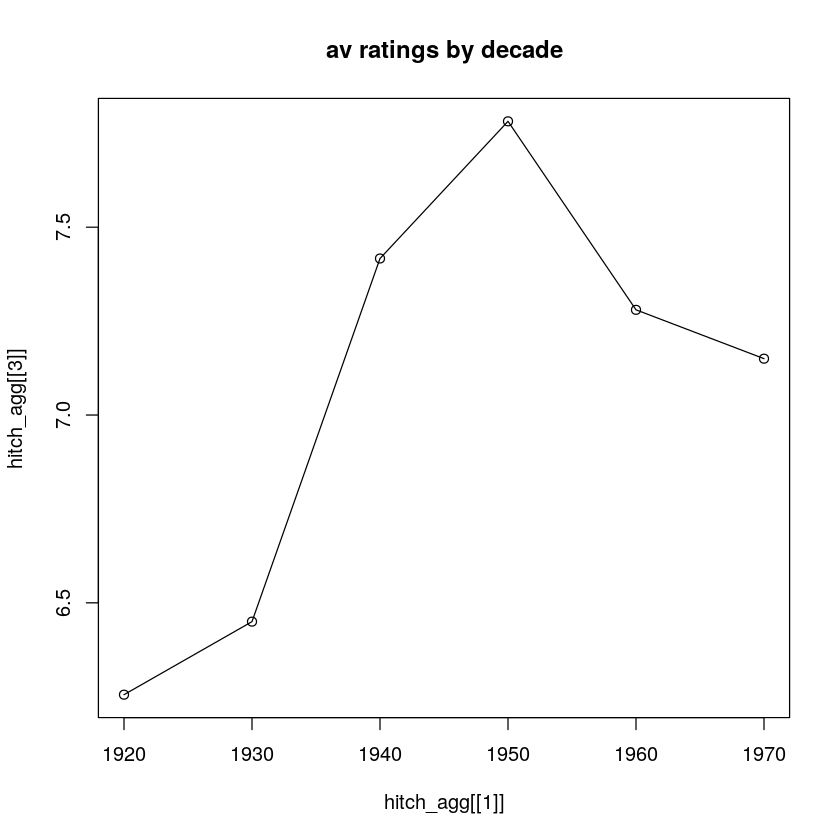

In [80]:
plot(x = hitch_agg[[1]], y = hitch_agg[[3]], main = "av ratings by decade")
lines(x = hitch_agg[[1]], y = hitch_agg[[3]], type = "l")

## Using dbplyr package (optional)

Now let's go through a final example using tidyverse and data.table and an R package called "dbplyr" that incorporates dplyr verbes, converts a dplyr pipe to an sql query and executes remotely.

Apart from dbplyr usage, this example will be a simple showcase of tidyverse and data.table tools

In [81]:
library(dbplyr)
library(tidyverse)
library(data.table)
library(RPostgreSQL)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::ident()  masks dbplyr::ident()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::sql()    masks dbplyr::sql()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



### Data connection and querying

In [82]:
drvv <- dbDriver("PostgreSQL")
drvv

<PostgreSQLDriver>

Create a connection to a database using the driver

In [83]:
con <- dbConnect(drvv,
                 dbname = "imdb2",
                 host = "localhost",
                 port = 5432,
                 user = "postgres")

con

<PostgreSQLConnection>

And create a remote source object:

In [84]:
title_basics <- tbl(con, "title_basics")

In [85]:
title_basics

# Source:   table<title_basics> [?? x 9]
# Database: postgres 11.0.5 [postgres@localhost:5432/imdb2]
   tconst titletype primarytitle originaltitle isadult startyear endyear
   <chr>  <chr>     <chr>        <chr>         <lgl>       <int>   <int>
 1 tt000… short     Carmencita   Carmencita    FALSE        1894      NA
 2 tt000… short     Le clown et… Le clown et … FALSE        1892      NA
 3 tt000… short     Pauvre Pier… Pauvre Pierr… FALSE        1892      NA
 4 tt000… short     Un bon bock  Un bon bock   FALSE        1892      NA
 5 tt000… short     Blacksmith … Blacksmith S… FALSE        1893      NA
 6 tt000… short     Chinese Opi… Chinese Opiu… FALSE        1894      NA
 7 tt000… short     Corbett and… Corbett and … FALSE        1894      NA
 8 tt000… short     Edison Kine… Edison Kinet… FALSE        1894      NA
 9 tt000… movie     Miss Jerry   Miss Jerry    FALSE        1894      NA
10 tt000… short     Employees L… La sortie de… FALSE        1895      NA
# … with more rows, and

Now let's create an sqlquery using dplyr verbes:

- Select genres and startyear columns
- Filter for startyear between 1950-2017, movie titletype and exclude missing genres
- Create a new column "count" for the record count (of any column)
- Group by genres and startyear and return the count of records

In [86]:
query1 <- title_basics %>% select(c("titletype", "genres", "startyear")) %>%
filter(between(startyear, 1950, 2017) &
       !is.na(genres) &
       titletype == "movie") %>%
group_by(genres, startyear) %>%
summarise(count = n())

This is lazy query it is not executed and returned yet:

In [87]:
query1

# Source:   lazy query [?? x 3]
# Database: postgres 11.0.5 [postgres@localhost:5432/imdb2]
# Groups:   genres
   genres startyear count
   <chr>      <int> <dbl>
 1 Action      1950     7
 2 Action      1951     1
 3 Action      1952     7
 4 Action      1953     9
 5 Action      1954    10
 6 Action      1955    29
 7 Action      1956    33
 8 Action      1957    24
 9 Action      1958    32
10 Action      1959    33
# … with more rows

Show the resulting sql query:

In [88]:
query1 %>%show_query

<SQL>
SELECT "genres", "startyear", COUNT(*) AS "count"
FROM (SELECT "titletype", "genres", "startyear"
FROM "title_basics") "dbplyr_002"
WHERE ("startyear" BETWEEN 1950.0 AND 2017.0 AND NOT((("genres") IS NULL)) AND "titletype" = 'movie')
GROUP BY "genres", "startyear"


Execute and collect the data:

In [89]:
table1 <- query1 %>% collect

### Data exploration and wrangling

Summarize the data:

In [90]:
str(table1)

Classes ‘grouped_df’, ‘tbl_df’, ‘tbl’ and 'data.frame':	21012 obs. of  3 variables:
 $ genres   : chr  "Action" "Action" "Action" "Action" ...
 $ startyear: int  1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 ...
 $ count    : num  7 1 7 9 10 29 33 24 32 33 ...
 - attr(*, "groups")=Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1320 obs. of  2 variables:
  ..$ genres: chr  "Action" "Action,Adult" "Action,Adult,Adventure" "Action,Adult,Comedy" ...
  ..$ .rows :List of 1320
  .. ..$ : int  1 2 3 4 5 6 7 8 9 10 ...
  .. ..$ : int  69 70 71 72 73 74 75
  .. ..$ : int 76
  .. ..$ : int  77 78 79 80
  .. ..$ : int  81 82 83 84 85 86
  .. ..$ : int 87
  .. ..$ : int  88 89 90
  .. ..$ : int 91
  .. ..$ : int 92
  .. ..$ : int 93
  .. ..$ : int  94 95 96 97 98 99 100 101 102 103 ...
  .. ..$ : int  162 163 164 165 166 167 168 169 170 171 ...
  .. ..$ : int  205 206 207 208 209 210 211 212 213 214 ...
  .. ..$ : int  232 233 234 235 236 237 238 239 240 241 ...
  .. ..$ : int  298 299 300 301 302 

In [91]:
table1 %>% glimpse

Observations: 21,012
Variables: 3
Groups: genres [1,320]
$ genres    <chr> "Action", "Action", "Action", "Action", "Action", "Action",…
$ startyear <int> 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,…
$ count     <dbl> 7, 1, 7, 9, 10, 29, 33, 24, 32, 33, 43, 55, 54, 54, 87, 85,…


Get unique values:

In [92]:
table1 %>% select(-count) %>% sapply(unique)

$genres
   [1] "Action"                           "Action,Adult"                    
   [3] "Action,Adult,Adventure"           "Action,Adult,Comedy"             
   [5] "Action,Adult,Crime"               "Action,Adult,Documentary"        
   [7] "Action,Adult,Drama"               "Action,Adult,Fantasy"            
   [9] "Action,Adult,Horror"              "Action,Adult,Western"            
  [11] "Action,Adventure"                 "Action,Adventure,Animation"      
  [13] "Action,Adventure,Biography"       "Action,Adventure,Comedy"         
  [15] "Action,Adventure,Crime"           "Action,Adventure,Documentary"    
  [17] "Action,Adventure,Drama"           "Action,Adventure,Family"         
  [19] "Action,Adventure,Fantasy"         "Action,Adventure,History"        
  [21] "Action,Adventure,Horror"          "Action,Adventure,Music"          
  [23] "Action,Adventure,Musical"         "Action,Adventure,Mystery"        
  [25] "Action,Adventure,Romance"         "Action,Adventure,Sci-Fi"         
  [27] "Action,Adventure,Sport"           "Action,Adventure,Thriller"       
  [29] "Action,Adventure,War"             "Action,Adventure,Western"        
  [31] "Action,Animation"                 "Action,Animation,Biography"      
  [33] "Action,Animation,Comedy"          "Action,Animation,Crime"          
  [35] "Action,Animation,Documentary"     "Action,Animation,Drama"          
  [37] "Action,Animation,Family"          "Action,Animation,Fantasy"        
  [39] "Action,Animation,History"         "Action,Animation,Horror"         
  [41] "Action,Animation,Music"           "Action,Animation,Musical"        
  [43] "Action,Animation,Mystery"         "Action,Animation,Romance"        
  [45] "Action,Animation,Sci-Fi"          "Action,Animation,Sport"          
  [47] "Action,Animation,Thriller"        "Action,Animation,Western"        
  [49] "Action,Biography"                 "Action,Biography,Comedy"         
  [51] "Action,Biography,Crime"           "Action,Biography,Documentary"    
  [53] "Action,Biography,Drama"           "Action,Biography,Fantasy"        
  [55] "Action,Biography,History"         "Action,Biography,Sci-Fi"         
  [57] "Action,Biography,Sport"           "Action,Biography,Thriller"       
  [59] "Action,Biography,War"             "Action,Biography,Western"        
  [61] "Action,Comedy"                    "Action,Comedy,Crime"             
  [63] "Action,Comedy,Documentary"        "Action,Comedy,Drama"             
  [65] "Action,Comedy,Family"             "Action,Comedy,Fantasy"           
  [67] "Action,Comedy,History"            "Action,Comedy,Horror"            
  [69] "Action,Comedy,Music"              "Action,Comedy,Musical"           
  [71] "Action,Comedy,Mystery"            "Action,Comedy,Romance"           
  [73] "Action,Comedy,Sci-Fi"             "Action,Comedy,Sport"             
  [75] "Action,Comedy,Thriller"           "Action,Comedy,War"               
  [77] "Action,Comedy,Western"            "Action,Crime"                    
  [79] "Action,Crime,Documentary"         "Action,Crime,Drama"              
  [81] "Action,Crime,Fantasy"             "Action,Crime,Film-Noir"          
  [83] "Action,Crime,History"             "Action,Crime,Horror"             
  [85] "Action,Crime,Music"               "Action,Crime,Musical"            
  [87] "Action,Crime,Mystery"             "Action,Crime,News"               
  [89] "Action,Crime,Romance"             "Action,Crime,Sci-Fi"             
  [91] "Action,Crime,Sport"               "Action,Crime,Thriller"           
  [93] "Action,Crime,Western"             "Action,Documentary"              
  [95] "Action,Documentary,Drama"         "Action,Documentary,Family"       
  [97] "Action,Documentary,Fantasy"       "Action,Documentary,History"      
  [99] "Action,Documentary,Horror"        "Action,Documentary,Music"        
 [101] "Action,Documentary,Musical"       "Action,Documentary,Mystery"      
 [103] "Action,Documentary,News"          "Action,Documentary,Rom

Any missing values?

In [93]:
which(!complete.cases(table1))

integer(0)

Convert to a data.table object:

In [94]:
setDT(table1)

Now what we will do with this data is that we will explore the count of multiple genres in titles:

Let's create a new column that shows how many genres each movie has:

In [95]:
table1[,genrec := stringr::str_extract_all(genres, ",", simplify= T) %>% length %>% "+"(1),
       by = 1:nrow(table1)]

See how "genres" and "genrec" columns are related:

In [96]:
table1[,.SD[1], by = genres]

genres,startyear,count,genrec
<chr>,<int>,<dbl>,<dbl>
Action,1950,7,1
"Action,Adult",1975,1,2
"Action,Adult,Adventure",1990,1,3
"Action,Adult,Comedy",1973,1,3
"Action,Adult,Crime",1973,1,3
"Action,Adult,Documentary",2013,1,3
"Action,Adult,Drama",1983,2,3
"Action,Adult,Fantasy",1987,1,3
"Action,Adult,Horror",1994,1,3


Now let's create contingency tables of genre counts as proportions for each startyear:

In [107]:
table2 <- table1[,.(countx = sum(count)), by = c("startyear", "genrec")]

In [111]:
table3 <- table2[, .(countr = countx / sum(countx), genrec), by = "startyear"]

In [97]:
genre_counts <- table1[, as.list(table(genrec) %>% prop.table %>% "*"(100) %>% round(2)),
                 by = startyear]
genre_counts

startyear,1,2,3
<int>,<dbl>,<dbl>,<dbl>
1950,11.90,39.29,48.81
1951,9.45,33.83,56.72
1952,10.20,30.10,59.69
1953,9.85,35.47,54.68
1954,10.05,37.19,52.76
1955,10.00,34.00,56.00
1956,9.22,33.98,56.80
1957,9.66,32.85,57.49
1958,9.86,34.74,55.40


However, in time, more genre combinations inflate the total count of those unique combinations. We should also aggregate the movie counts in these genre combinations as such:

In [118]:
table2 <- table1[,.(countx = sum(count)), by = c("startyear", "genrec")]
table3 <- table2[, .(countr = countx / sum(countx), genrec), by = "startyear"]

table3 %>% spread("genrec", "countr")

startyear,1,2,3
<int>,<dbl>,<dbl>,<dbl>
1950,0.5822436,0.2532691,0.1644873
1951,0.5318560,0.2749307,0.1932133
1952,0.5965946,0.2305174,0.1728880
1953,0.5464446,0.2696989,0.1838565
1954,0.5284605,0.3059508,0.1655886
1955,0.5481852,0.2703379,0.1814768
1956,0.5820012,0.2545885,0.1634103
1957,0.5646295,0.2731206,0.1622499
1958,0.5503426,0.3015287,0.1481286


### Data visualization

Let's visualize the proportions of 1, 2, and 3 genred movies (first the count of unique genre combinations without weighting with movie counts) as a stacked area chart:

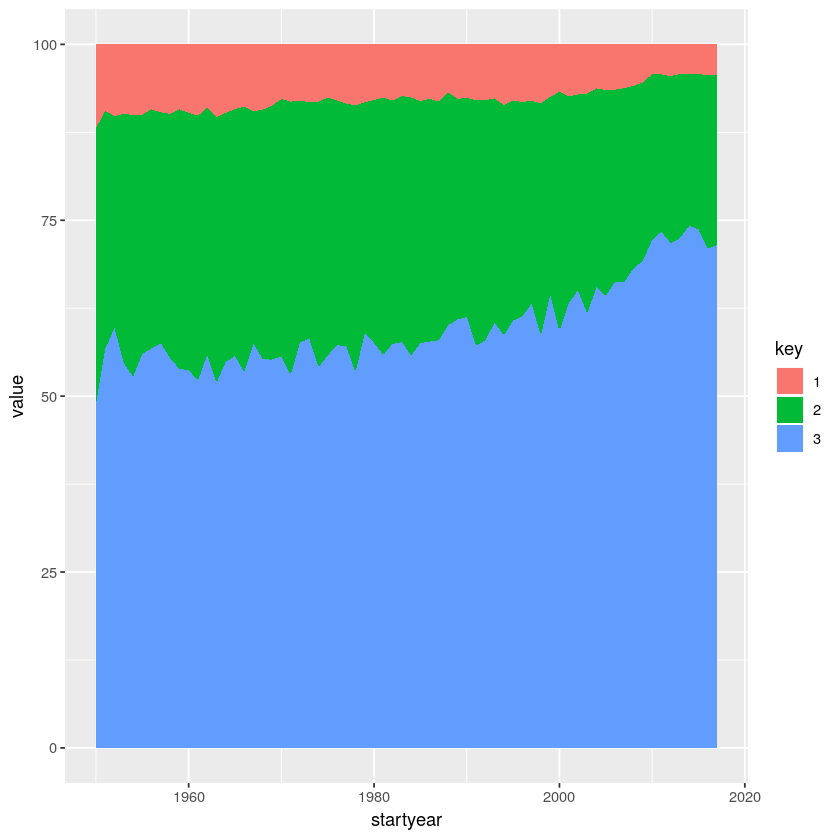

In [98]:
plot1 <- genre_counts %>%
    gather("key", "value", -startyear) %>%
    ggplot(aes(x = startyear, y = value, fill = key)) +
        geom_area()
        
plot1

We can also visualize interactively using plotly:

In [ ]:
plot1 %>% plotly::ggplotly()

See that over time movies represent multiple genres as opposed to single genres to a larger extent (increase in the area of "3").

However we should also try to visualize the summary data in which the count of movies in each unique genre combination is also used for weighting:

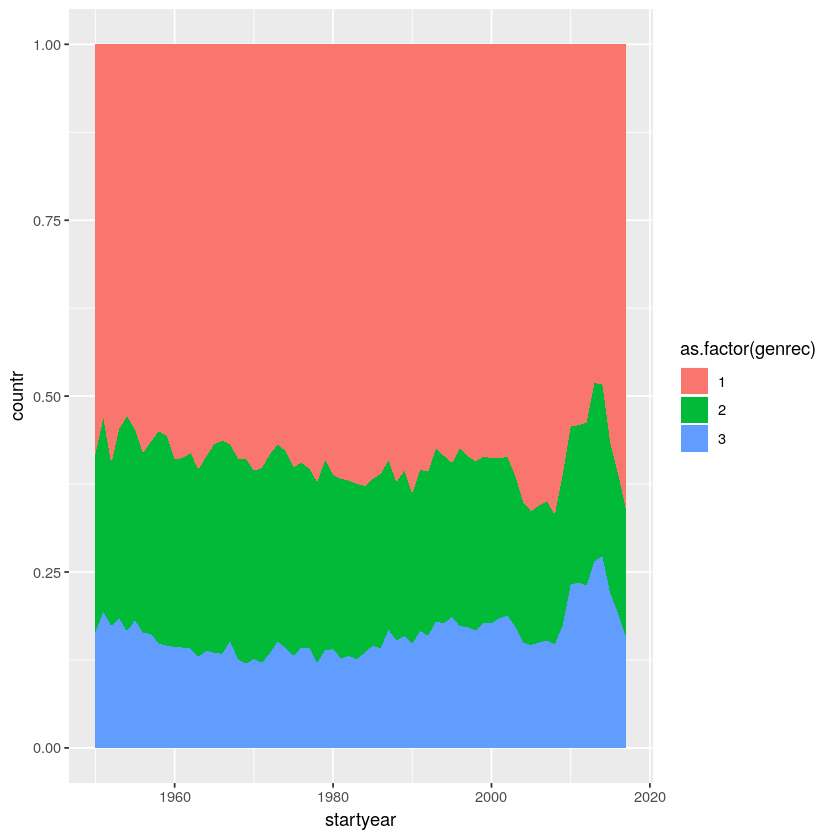

In [116]:
plot2 <- table3 %>%
    ggplot(aes(x = startyear, y = countr, fill = as.factor(genrec))) +
        geom_area()

plot2

We can also visualize interactively using plotly:

In [ ]:
plot2 %>% plotly::ggplotly()

Here, we see that, in fact the expansion of the share of movies with 3 categories is only due to more unique genre combinations over time. However total counts of moviesare dispersed across more categories. So the weightings with movie counts show that movies with single genres still dominate

# QUIZ

Enter the password provided and run the following cell:

In [ ]:
pass=
cat quiz_2019_01q.ipynb.crypt | \
openssl enc -aes-128-cbc -a -d -salt -pass pass:$pass 2> /dev/null > quiz_2019_01q.ipynb

Now open quiz_2019_01q.ipynb file and follow instructions